In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

In [2]:
plt.close('all')

## EDA

In [3]:
df = pd.read_csv('coffee_analysis.csv')
df.head()

,name,roaster,roast,loc_country,origin_1,origin_2,100g_USD,rating,review_date,desc_1,desc_2,desc_3
0,“Sweety” Espresso Blend,A.R.C.,Medium-Light,Hong Kong,Panama,Ethiopia,14.32,95,November 2017,"Evaluated as espresso. Sweet-toned, deeply ric...",An espresso blend comprised of coffees from Pa...,A radiant espresso blend that shines equally i...
1,Flora Blend Espresso,A.R.C.,Medium-Light,Hong Kong,Africa,Asia Pacific,9.05,94,November 2017,"Evaluated as espresso. Sweetly tart, floral-to...",An espresso blend comprised of coffees from Af...,"A floral-driven straight shot, amplified with ..."
2,Ethiopia Shakiso Mormora,Revel Coffee,Medium-Light,United States,Guji Zone,Southern Ethiopia,4.70,92,November 2017,"Crisply sweet, cocoa-toned. Lemon blossom, roa...",This coffee tied for the third-highest rating ...,"A gently spice-toned, floral- driven wet-proce..."
3,Ethiopia Suke Quto,Roast House,Medium-Light,United States,Guji Zone,Oromia Region,4.19,92,November 2017,"Delicate, sweetly spice-toned. Pink peppercorn...",This coffee tied for the third-highest rating ...,Lavender-like flowers and hints of zesty pink ...
4,Ethiopia Gedeb Halo Beriti,Big Creek Coffee Roasters,Medium,United States,Gedeb District,Gedeo Zone,4.85,94,November 2017,"Deeply sweet, subtly pungent. Honey, pear, tan...",Southern Ethiopia coffees like this one are pr...,A deeply and generously lush cup saved from se...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2095 entries, 0 to 2094
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         2095 non-null   object 
 1   roaster      2095 non-null   object 
 2   roast        2080 non-null   object 
 3   loc_country  2095 non-null   object 
 4   origin_1     2095 non-null   object 
 5   origin_2     2095 non-null   object 
 6   100g_USD     2095 non-null   float64
 7   rating       2095 non-null   int64  
 8   review_date  2095 non-null   object 
 9   desc_1       2095 non-null   object 
 10  desc_2       2095 non-null   object 
 11  desc_3       2093 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 196.5+ KB


### **Find missing values**

In [5]:
df.isnull().sum()

name            0
roaster         0
roast          15
loc_country     0
origin_1        0
origin_2        0
100g_USD        0
rating          0
review_date     0
desc_1          0
desc_2          0
desc_3          2
dtype: int64

### **Drop rows with missing values since its only 17 values**

In [6]:
df.dropna(inplace=True)
df.describe()

,100g_USD,rating
count,2078.000000,2078.000000
mean,9.088239,93.112608
std,10.341998,1.563863
min,0.170000,84.000000
25%,4.930000,92.000000
50%,5.860000,93.000000
75%,8.770000,94.000000
max,132.280000,98.000000


### **Find categorical column cardinality**

In [7]:
df.select_dtypes(include=['object']).nunique()

name           1896
roaster         421
roast             5
loc_country      19
origin_1        611
origin_2        357
review_date      61
desc_1         2075
desc_2         2012
desc_3         2075
dtype: int64

### **Plot the distribution of the rating column**

<Axes: >

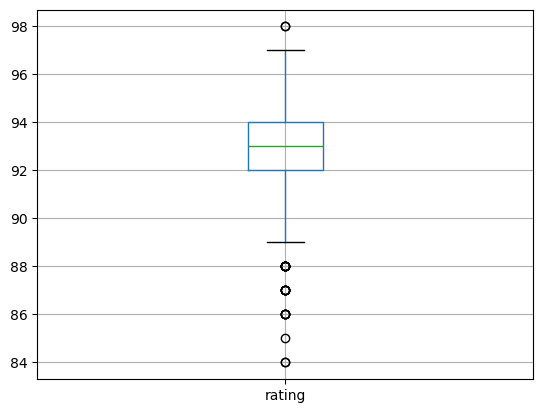

In [8]:
df.boxplot(column="rating")

### **Split data into numerical and categorical**

In [9]:
categorical_columns = df.select_dtypes(include=["object"]).columns
numerical_columns = df.drop(columns=categorical_columns).columns

### **Find the correlation of each variable with price**

In [10]:
numerical_corr = df[numerical_columns].corr()['rating'].sort_values(ascending=False)
print(numerical_corr)
for col in categorical_columns:
    if col not in ["name", "desc_1", "desc_2", "desc_3", "roast"]:
        means = df.groupby(col)["rating"].mean()
        overall_mean = df["rating"].mean()
        categorical_corr = means.corr(pd.Series([overall_mean] * len(means), index=means.index))
        with np.errstate(divide="ignore", invalid="ignore"): 
            print(col + ": " + str(categorical_corr))

rating      1.000000
100g_USD    0.272184
Name: rating, dtype: float64
roaster: 2.452196372799741e-15
loc_country: nan
origin_1: -4.127892162594409e-15
origin_2: 6.725141870504017e-15
review_date: nan


c:\Users\leebt2\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\leebt2\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\leebt2\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\leebt2\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


### **Create a boxplot for each categorical column in relation to rating**

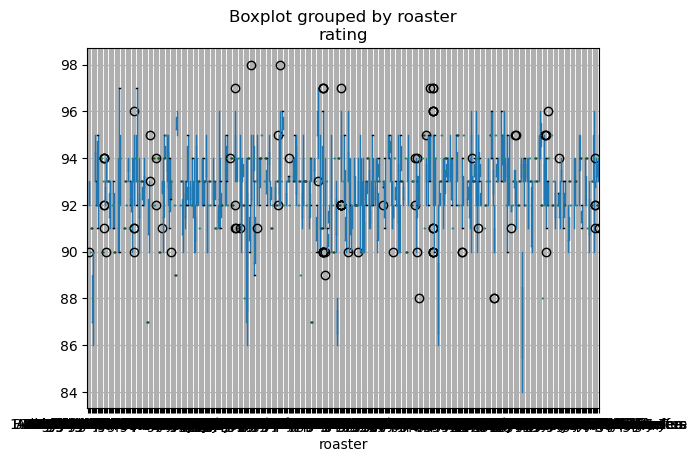

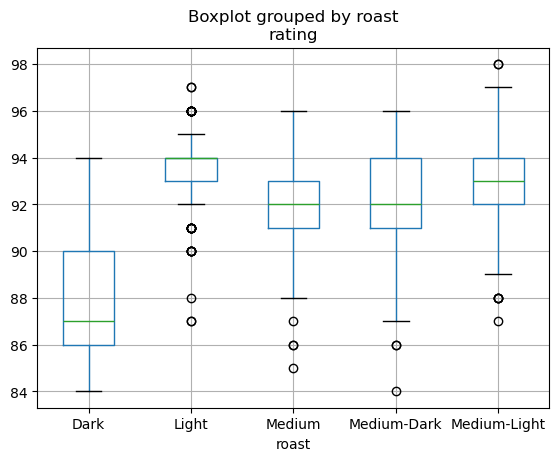

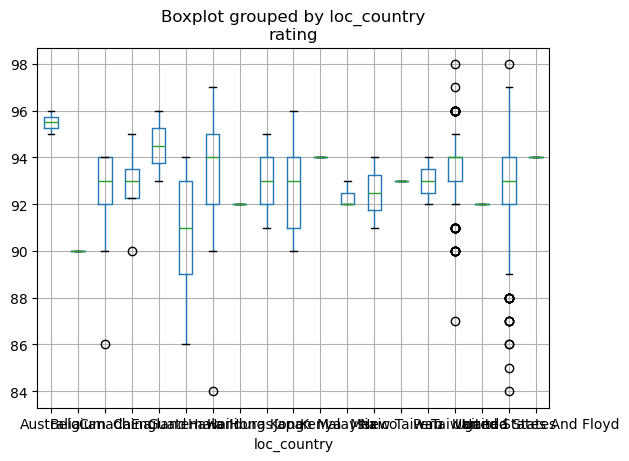

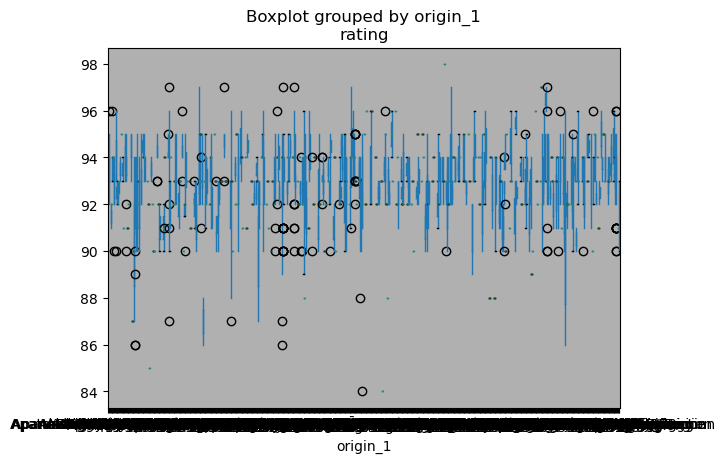

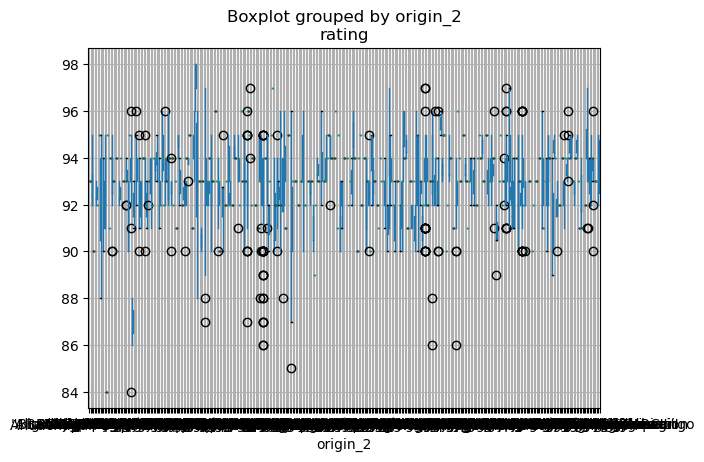

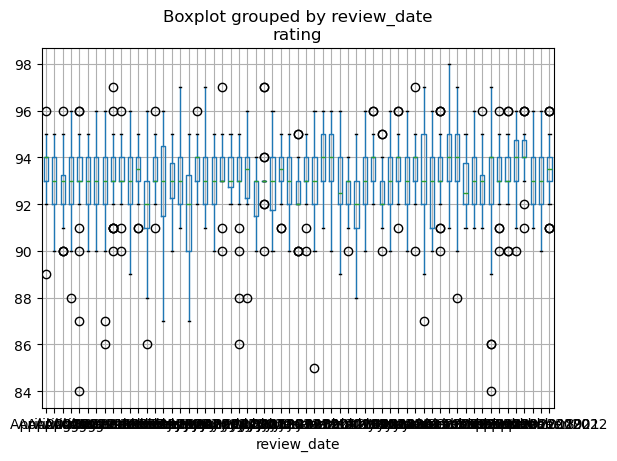

In [11]:
for col in categorical_columns:
    # Do not include columns with very high cardinality
    if col not in ["name", "desc_1", "desc_2", "desc_3"]:
        df.boxplot(column="rating", by=col)
        plt.show()

### **Create a scatter plot for every numerical column in relation to price**

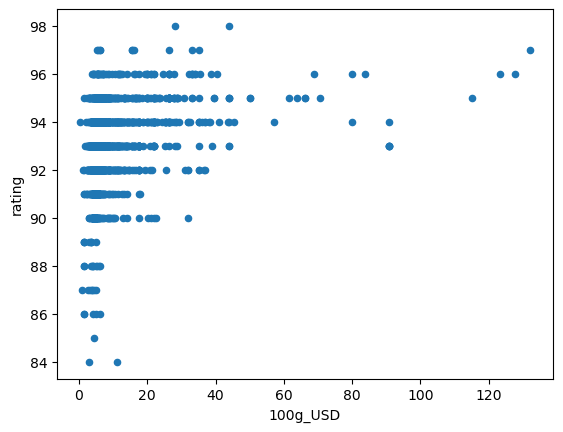

In [12]:
numerical_columns_no_features = numerical_columns.drop(["rating"])
for col in numerical_columns_no_features:
    df.plot.scatter(x=col, y="rating")
    plt.show()

## **Simple Bias Regressor (Baseline)**

### **Simple bias baseline mse**

In [13]:
y = df["rating"]
y_pred = [y.mean()] * len(y)
mse = mean_squared_error(y, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 2.4444897320200347


## **Single Feature Linear Regression**

In [14]:
# features that look like they could be useful for prediction
pot_cat_features = ["loc_country", "roast"]
pot_num_features = ["100g_USD"]

# train linear regression model on a single categorical feature
for f in pot_cat_features:
    df2 = df.copy()
    df2 = df2[["rating", f]]
    df2.dropna(subset=[f], inplace=True)
    X = df2[[f]]
    y = df2["rating"]
    X = pd.get_dummies(X, columns=[f])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    print(f"Score for {f}: {lr.score(X_test, y_test)}")

# train linear regression model on a single numerical feature
for f in pot_num_features:
    df2 = df.copy()
    df2 = df2[["rating", f]]
    df2.dropna(subset=[f], inplace=True)
    X = df2[[f]]
    y = df2["rating"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    print(f"Score for {f}: {lr.score(X_test, y_test)}")


Score for loc_country: -9.310925990671116e+24
Score for roast: 0.020207363245150933
Score for 100g_USD: 0.05573202036912084


All three of these features very slightly beat the simple bias regressor showing a small level of linear correlation with the target

In [15]:
# train knn regressor on a single categorical feature
for f in pot_cat_features:
    df2 = df.copy()
    df2 = df2[["rating", f]]
    df2.dropna(subset=[f], inplace=True)
    X = df2[[f]]
    y = df2["rating"]
    X = pd.get_dummies(X, columns=[f])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    params = {'n_neighbors':list(range(1, 50))}
    lr = KNeighborsRegressor()
    lr = GridSearchCV(lr, params, cv=5)
    lr.fit(X_train, y_train)
    print(lr.best_params_)
    print(f"Score for {f}: {lr.score(X_test, y_test)}")

# train knn regressor on a single numerical feature
for f in pot_num_features:
    df2 = df.copy()
    df2 = df2[["rating", f]]
    df2.dropna(subset=[f], inplace=True)
    X = df2[[f]]
    y = df2["rating"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    params = {'n_neighbors':list(range(1, 50))}
    lr = KNeighborsRegressor()
    lr = GridSearchCV(lr, params, cv=5)
    lr.fit(X_train, y_train)
    print(lr.best_params_)
    print(f"Score for {f}: {lr.score(X_test, y_test)}")

{'n_neighbors': 28}
Score for loc_country: 0.02291177399038391
{'n_neighbors': 13}
Score for roast: 0.04942656574895954
{'n_neighbors': 19}
Score for 100g_USD: 0.09854933075721284


Using KNN regressors performs better for the '100g_USD' and 'loc_country' features, as they demonstrate a better spatial correlation with the target. However, the 'roast' feature is now worse than the baseline regressor at predicting the target. 

## **Feature Selection (Linear Regression)**

In [16]:
# all features to be used in the model
cat_features = ["loc_country", "roast"]
features = ["loc_country", "roast", "100g_USD"]

R2_arr = []
MSE_arr = []
feature_subset_arr = []

# Use every possible subset of features to find the optimal set
for mask in range(1, 1<<len(features)):
    feature_subset = [features[i] for i in range(len(features)) if mask & (1 << i)]
    cat_features_subset = [f for f in feature_subset if f in cat_features]
    feature_subset_arr.append(feature_subset)

    df2 = df.copy()
    df2.dropna(subset=feature_subset, inplace=True)
    X = df2[feature_subset]
    y = df2["rating"]

    # One hot encode categorical features
    X = pd.get_dummies(X, columns=cat_features_subset)

    # Train test split (80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # train linear regression model
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # score linear regression model
    R2 = lr.score(X_test, y_test)
    R2_arr.append(R2)
    y_pred = lr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    MSE_arr.append(mse)


In [17]:
# display optimal feature subset results
idx = np.argmax(R2_arr)
print(f"Optimal feature subset: {feature_subset_arr[idx]}")
print(f"R2: {R2_arr[idx]}")
print(f"MSE: {MSE_arr[idx]}")
optimal_features = feature_subset_arr[idx]
optimal_cat_features = [f for f in optimal_features if f in cat_features]

Optimal feature subset: ['loc_country', 'roast', '100g_USD']
R2: 0.10645179902592716
MSE: 2.3326556597312944


Using only these three features with linear regression does not predict rating well; hoewver, it does beat the baseline simple bias regressor. 

In [18]:
# Train optimal model
df2 = df.copy()
df2.dropna(subset=optimal_features, inplace=True)
X = df2[optimal_features]
y = df2["rating"]

# One hot encode categorical features
X = pd.get_dummies(X, columns=optimal_cat_features)

# Train test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# train linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# get optimal predictions
y_pred = lr.predict(X_test)

In [19]:
# view the lr coefficients
coefficients = pd.DataFrame(lr.coef_, X.columns, columns=["coef"])
coefficients.sort_values(by="coef", ascending=False)

,coef
100g_USD,3.749238e-01
roast_Light,1.383957e-01
loc_country_Taiwan,1.352554e-01
roast_Medium-Light,1.165134e-01
loc_country_Australia,3.599782e-02
loc_country_Hawai'i,2.486769e-02
loc_country_Mexico,1.244119e-02
loc_country_Honduras,1.387779e-17
loc_country_New Taiwan,0.000000e+00
loc_country_United States And Floyd,0.000000e+00


The price (100g_USD) feature seems to be the most important for predicting rating

## **Feature Selection (Polynomial price, KNN and LR)** 

In [20]:
cat_features = ["loc_country", "roast"]
base_features = ["loc_country", "roast"]
numeric_feature = "100g_USD"

price_variants = [f"{numeric_feature}^{i}" for i in range(1, 4)]

features = base_features + price_variants

R2_arr = []
MSE_arr = []
results_lr = []
results_knn = []

for j in range(1, 1 << len(features)):
    feature_subset = [features[i] for i in range(len(features)) if j & (1 << i)]

    df2 = df.copy()

    if price_variants[0] in feature_subset:
        df2[price_variants[0]] = df2[numeric_feature]
    if price_variants[1] in feature_subset:
        df2[price_variants[1]] = df2[numeric_feature] ** 2
    if price_variants[2] in feature_subset:
        df2[price_variants[2]] = df2[numeric_feature] ** 3

    X = df2[feature_subset]
    y = df2["rating"]
    cat_features_subset = [f for f in feature_subset if f in cat_features]
    X = pd.get_dummies(X, columns=cat_features_subset)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    R2 = lr.score(X_test, y_test)
    y_pred = lr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    R2_arr.append(R2)
    MSE_arr.append(mse)
    results_lr.append(feature_subset)

    for i in range(1, 50):
        knn = KNeighborsRegressor(n_neighbors=i)
        knn.fit(X_train, y_train)
        y_pred_knn = knn.predict(X_test)
        mse_knn = mean_squared_error(y_test, y_pred_knn)
        r2_knn = knn.score(X_test, y_test)
        results_knn.append((mse_knn, r2_knn, feature_subset, i))

results = list(zip(MSE_arr, R2_arr, results_lr))
results.sort()  
print(f"Linear Regression - Best MSE: {results[0][0]:.4f}, Best R2: {results[0][1]:.4f}, Features: {results[0][2]}")
best_knn = sorted(results_knn)[0]
print(f"KNN - Best MSE: {best_knn[0]:.4f}, R2: {best_knn[1]:.4f}, Features: {best_knn[2]}, K: {best_knn[3]}")

Linear Regression - Best MSE: 2.3327, Best R2: 0.1065, Features: ['loc_country', 'roast', '100g_USD^1']
KNN - Best MSE: 2.1133, R2: 0.1905, Features: ['loc_country', 'roast', '100g_USD^2'], K: 21


## **Ridge and Lasso Regression**

In [21]:
ridge = Ridge()
lasso = Lasso()

grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}

ridgeCV = GridSearchCV(ridge, param_grid=grid)
lassoCV = GridSearchCV(lasso, param_grid=grid)
ridgeCV.fit(X_train,y_train)
lassoCV.fit(X_train,y_train)

c:\Users\leebt2\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.126e+00, tolerance: 3.203e-01
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                   10000, 100000]})

In [22]:
# report validation scores
print('Ridge best score:',ridgeCV.best_score_)
print('Ridge best alpha:',ridgeCV.best_params_['alpha'])
print('Lasso best score:',lassoCV.best_score_)
print('Lasso best alpha:',lassoCV.best_params_['alpha'])

Ridge best score: 0.21785132620442393
Ridge best alpha: 1
Lasso best score: 0.21803984614319366
Lasso best alpha: 0.001


In [23]:
# run ridge and lasso on test set
ridgeCV = Ridge(alpha=100)
lassoCV = Lasso(alpha=0.01)
ridgeCV.fit(X_train,y_train)
lassoCV.fit(X_train,y_train)
ridgeCV.score(X_test,y_test)
print(f"Lasso R2: {lassoCV.score(X_test,y_test)}")
print(f"Ridge R2: {ridgeCV.score(X_test,y_test)}")

Lasso R2: 0.11534055956369316
Ridge R2: 0.11482383887391878


Ridge slightly outperforms Lasso and basic linear regression

## **Random Forest Regression**

c:\Users\leebt2\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


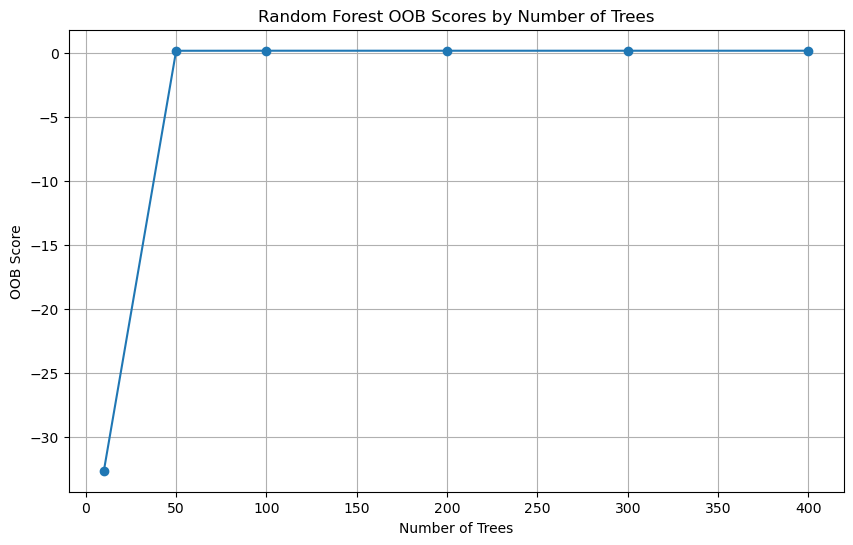

,num trees,oob
0,10,-32.643470
1,50,0.185830
2,100,0.189822
3,200,0.188945
4,300,0.188770
5,400,0.189572


In [24]:
oob_scores = []
tree_counts = [10, 50, 100, 200, 300, 400]  
for n_trees in tree_counts:
    model = RandomForestRegressor(n_estimators=n_trees, max_features=len(optimal_features)/3,
    oob_score=True, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    oob_scores.append(model.oob_score_)

plt.figure(figsize=(10, 6))
plt.plot(tree_counts, oob_scores, marker='o')
plt.title('Random Forest OOB Scores by Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('OOB Score')
plt.grid(True)
plt.show()

results = pd.DataFrame()
results['num trees'] = tree_counts
results['oob'] = oob_scores
results

In [25]:
# train and test random forest model with 100 trees
model = RandomForestRegressor(n_estimators=100, max_features=len(optimal_features)/3,
    oob_score=True, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Random Forest R2: {model.score(X_test, y_test)}")

Random Forest R2: 0.15354122443699736


Random forest is the best performing model using the three features we though would be usable given the preprocessing techniques learned in this class (One hot encoding and standardization). We will look into using embeddings in order to make use of textual features for further models

## **Gradient Boosting**

## **Embeddings**

In [27]:
from sentence_transformers import SentenceTransformer

ModuleNotFoundError: No module named 'sentence_transformers'

In [ ]:
# set sentences to desc_1 from df
sentences = df["desc_1"].tolist()

# load the model
model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = model.encode(sentences)
print(embeddings.shape)

# Calculate the embedding similarities
similarities = model.similarity(embeddings, embeddings)
print(similarities)

c:\Users\davidj\Desktop\CSSE415-Project\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\davidj\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Fal

(2078, 384)
tensor([[1.0000, 0.8157, 0.5124,  ..., 0.5689, 0.6467, 0.8649],
        [0.8157, 1.0000, 0.5156,  ..., 0.5736, 0.6757, 0.8103],
        [0.5124, 0.5156, 1.0000,  ..., 0.7070, 0.6616, 0.5064],
        ...,
        [0.5689, 0.5736, 0.7070,  ..., 1.0000, 0.7234, 0.5085],
        [0.6467, 0.6757, 0.6616,  ..., 0.7234, 1.0000, 0.6715],
        [0.8649, 0.8103, 0.5064,  ..., 0.5085, 0.6715, 1.0000]])
